# Ablation

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 10.07.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../utils")

In [3]:
import os
import warnings
from datetime import datetime

import mlflow
import numpy as np
import pandas as pd
import pickle
import plottable

from nichecompass.benchmarking import compute_benchmarking_metrics
from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

import scanpy as sc

from ablation_utils import *

### 1.2 Define Parameters

In [4]:
latent_key = "nichecompass_latent"
spatial_key = "spatial"
latent_knng_key = "nichecompass_latent_knng"
spatial_knng_key = "spatial_knng"
gp_names_key = "nichecompass_gp_names"

### 1.4 Run Notebook Setup

In [5]:
sc.set_figure_params(figsize=(6, 6))

In [6]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [7]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [12]:
# Set mlflow tracking server (run it on the defined port)
mlflow.set_tracking_uri("http://localhost:8999")

### 1.5 Configure Paths and Directories

In [55]:
artifact_folder_path = f"../../artifacts"
miscellaneous_folder_path = f"{artifact_folder_path}/miscellaneous"
figure_folder_path = f"{miscellaneous_folder_path}/ablation"

## 2. Ablation

### 2.1 Loss Weights (Edge Reconstruction, Gene Expression Reconstruction, KL Divergence) & Gene Program Mask

- Different combinations of the edge reconstruction loss and gene expression reconstruction loss weighting hyperparameters are tested.
- Three datasets are used (batch1 of Xenium Human Breast Cancer, batch1 of STARmap PLUS Mouse CNS, batch2 of Vizgen MERFISH Human Ovarian Cancer).
- Number of neighbors of the spatial neighborhood graph is varied between ```4```, ```8```, ```12```, and ```16```.
- For each dataset and 'n_neighbors', one run is performed with a fully connected gene program mask, one with an unfiltered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=1.0), one with a weakly filtered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=0.1), and one with a strongly filtered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=0.01).
- This results in a total of 48 runs per loss weight combination.

In [10]:
ablation_task = "loss_weights"
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns", "vizgen_merfish_human_ovarian_cancer"]
cell_type_keys = ["cell_states", "Main_molecular_cell_type", "cell_type"]
batch_keys = [None, None, None]
experiment_ids = [3, 4, 5]

In [66]:
ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"

In [ ]:
# Retrieve metrics and params of ablation runs from mlflow and store in summary df
summary_df = pd.DataFrame()
for dataset, experiment_id in zip(datasets, experiment_ids):
    runs_info = mlflow.list_run_infos(experiment_id)
    for run_info in runs_info:
        run = mlflow.get_run(run_info.run_uuid)
        if run.info.status == "RUNNING":
            continue
        run_dict = {"dataset": dataset}
        run_dict["timestamp"] = run.data.params["timestamp"]
        run_dict["val_auroc_score"] = run.data.metrics.get("val_auroc_score", np.nan)
        run_dict["val_gene_expr_mse_score"] = run.data.metrics.get("val_gene_expr_mse_score", np.nan)
        run_dict["lambda_edge_recon_"] = run.data.params["lambda_edge_recon_"]
        run_dict["lambda_gene_expr_recon_"] = run.data.params["lambda_gene_expr_recon_"]
        run_dict["n_neighbors"] = run.data.params["n_neighbors"]
        run_dict["nichenet_keep_target_genes_ratio"] = run.data.params["nichenet_keep_target_genes_ratio"]
        run_dict["add_fc_gps_instead_of_gp_dict_gps"] = run.data.params["add_fc_gps_instead_of_gp_dict_gps"]
        run_df = pd.DataFrame(run_dict, index=[0])
        summary_df = pd.concat([summary_df, run_df], ignore_index=True)
summary_df["loss_weights"] = summary_df.apply(lambda row: get_loss_weights(row), axis=1)
summary_df["gp_mask"] = summary_df.apply(lambda row: get_gp_mask(row), axis=1)

for dataset in datasets:
    summary_df[summary_df["dataset"] == dataset].to_csv(f"{miscellaneous_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv")

In [24]:
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{miscellaneous_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv", index_col=0)
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)

In [67]:
j = 0
for i in np.arange(20, 460, 20):
    temp_df = summary_df[j:i]
    temp_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{i}.csv")
    j = i

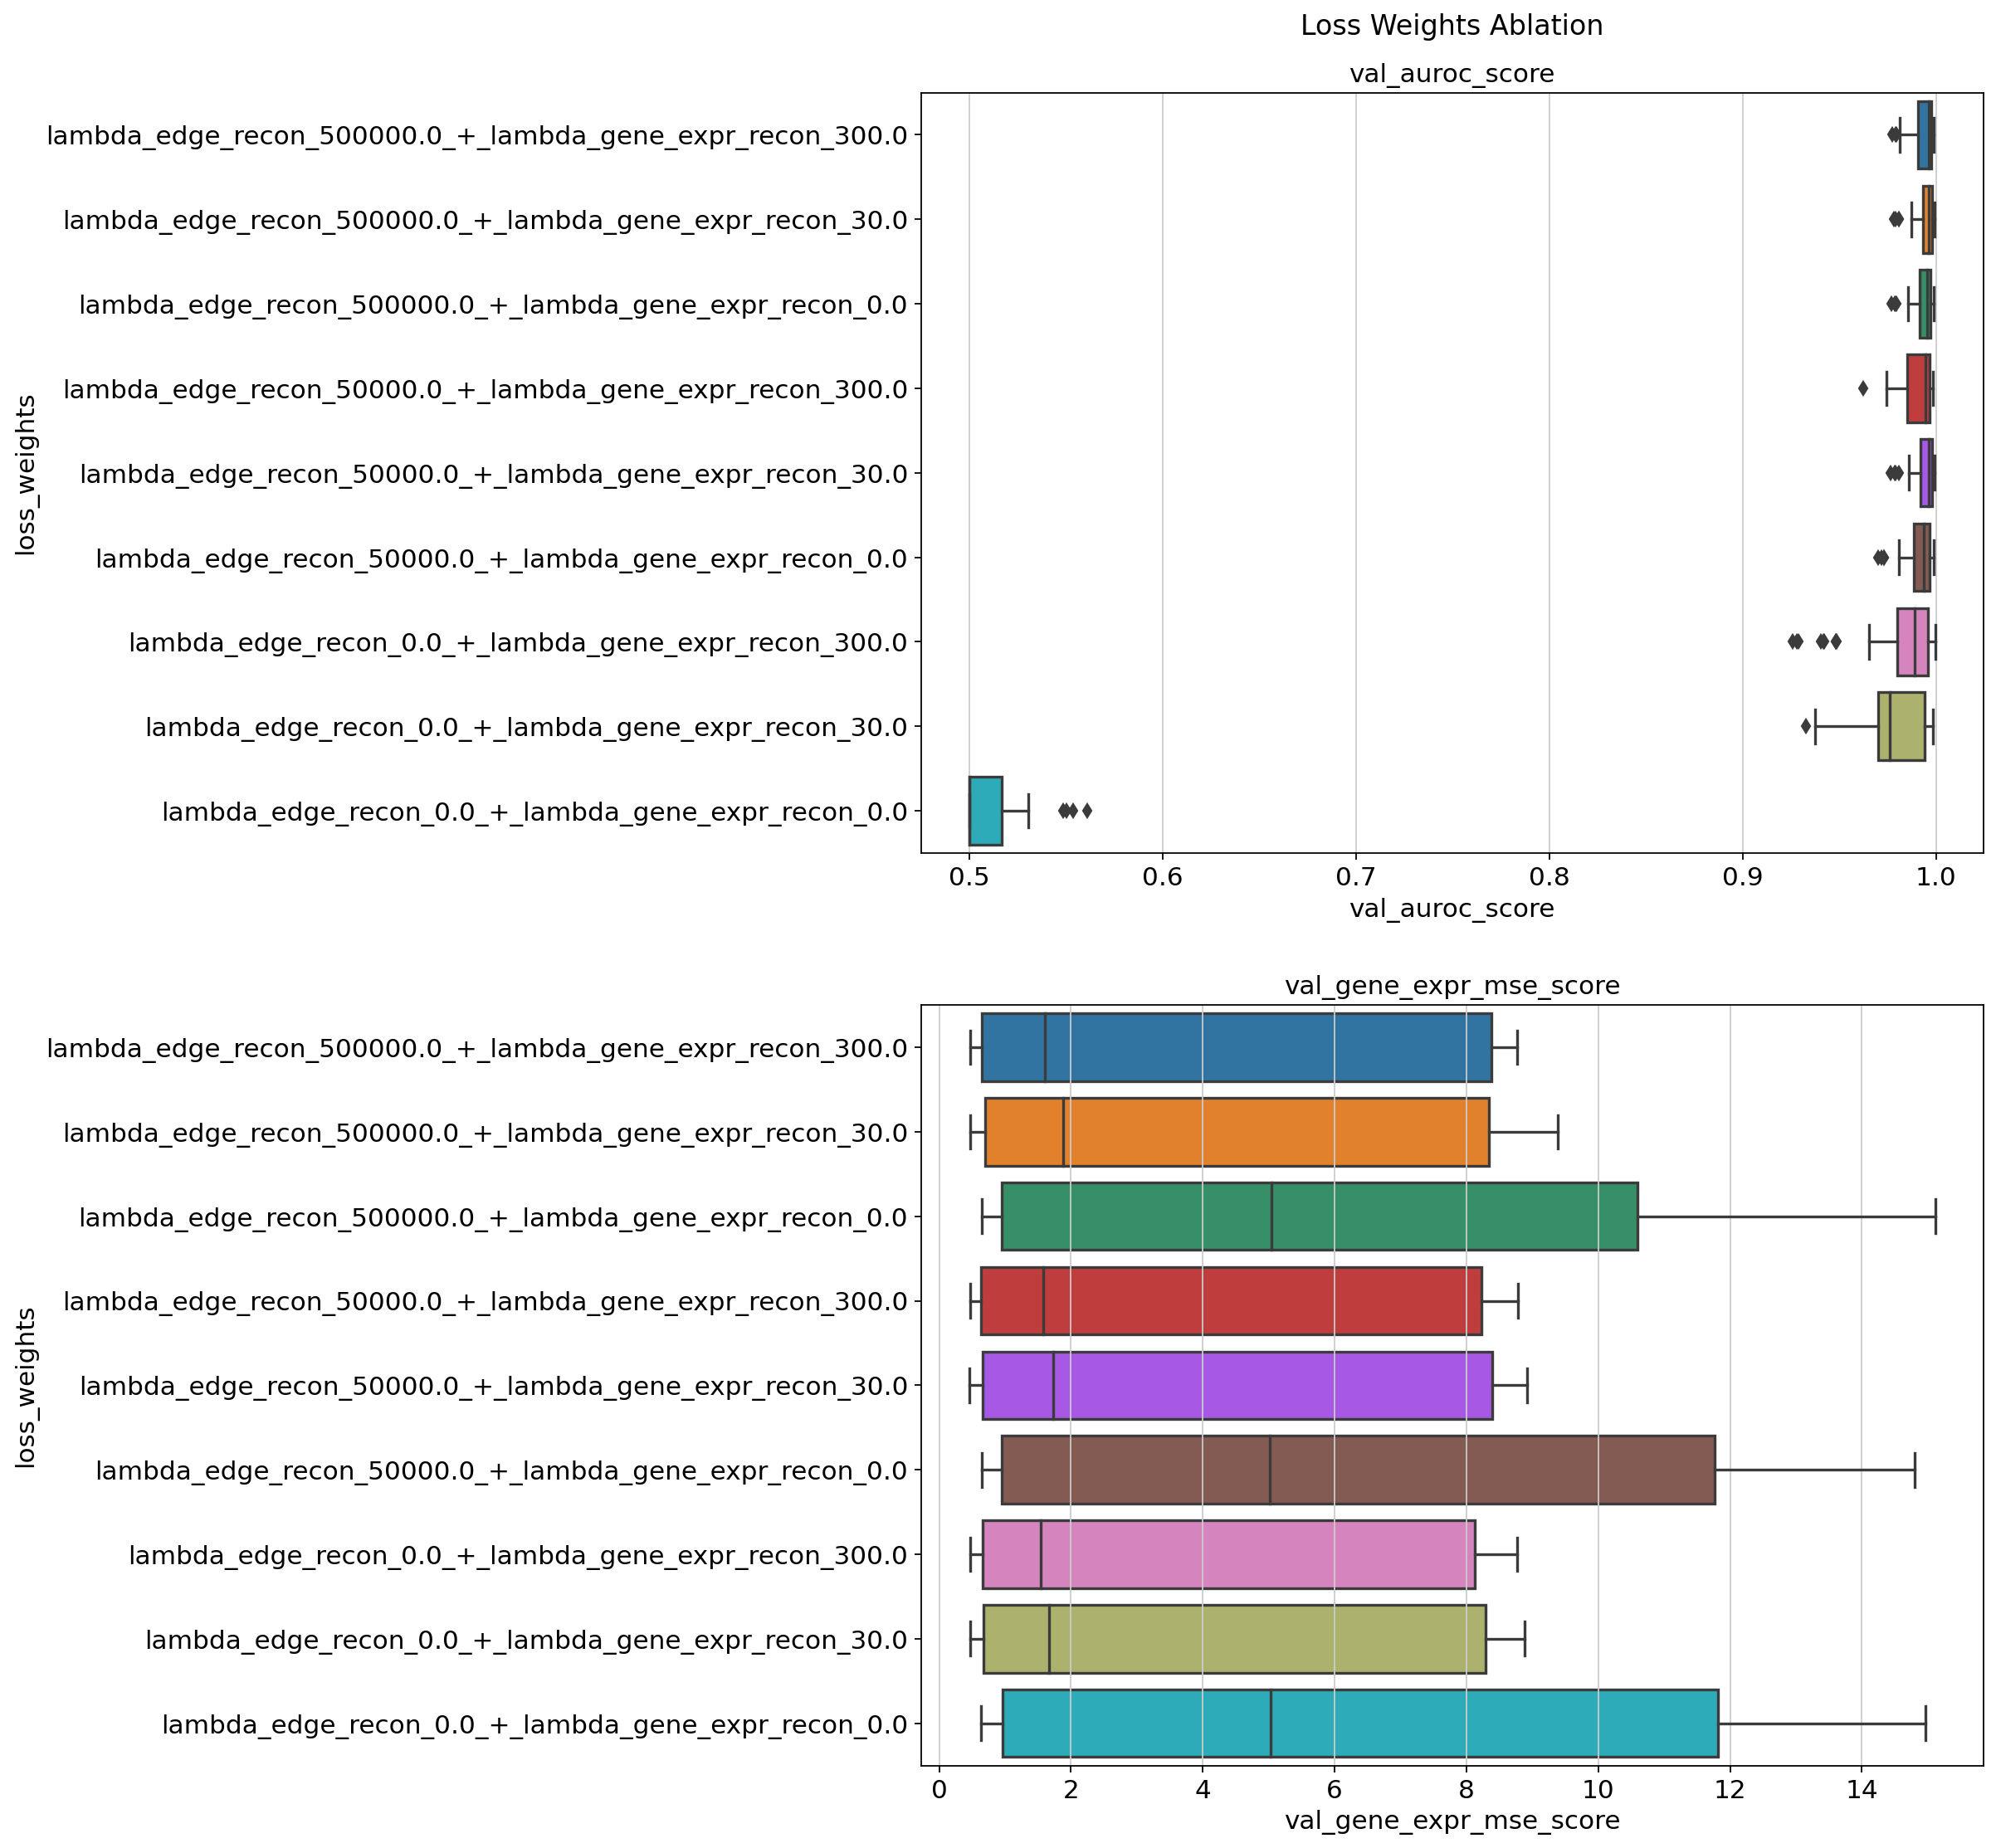

In [40]:
# Loss weights plot
plot_metrics(fig_title="Loss Weights Ablation",
             df=summary_df,
             group_col="loss_weights",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="loss_weights_ablation_metrics.png")

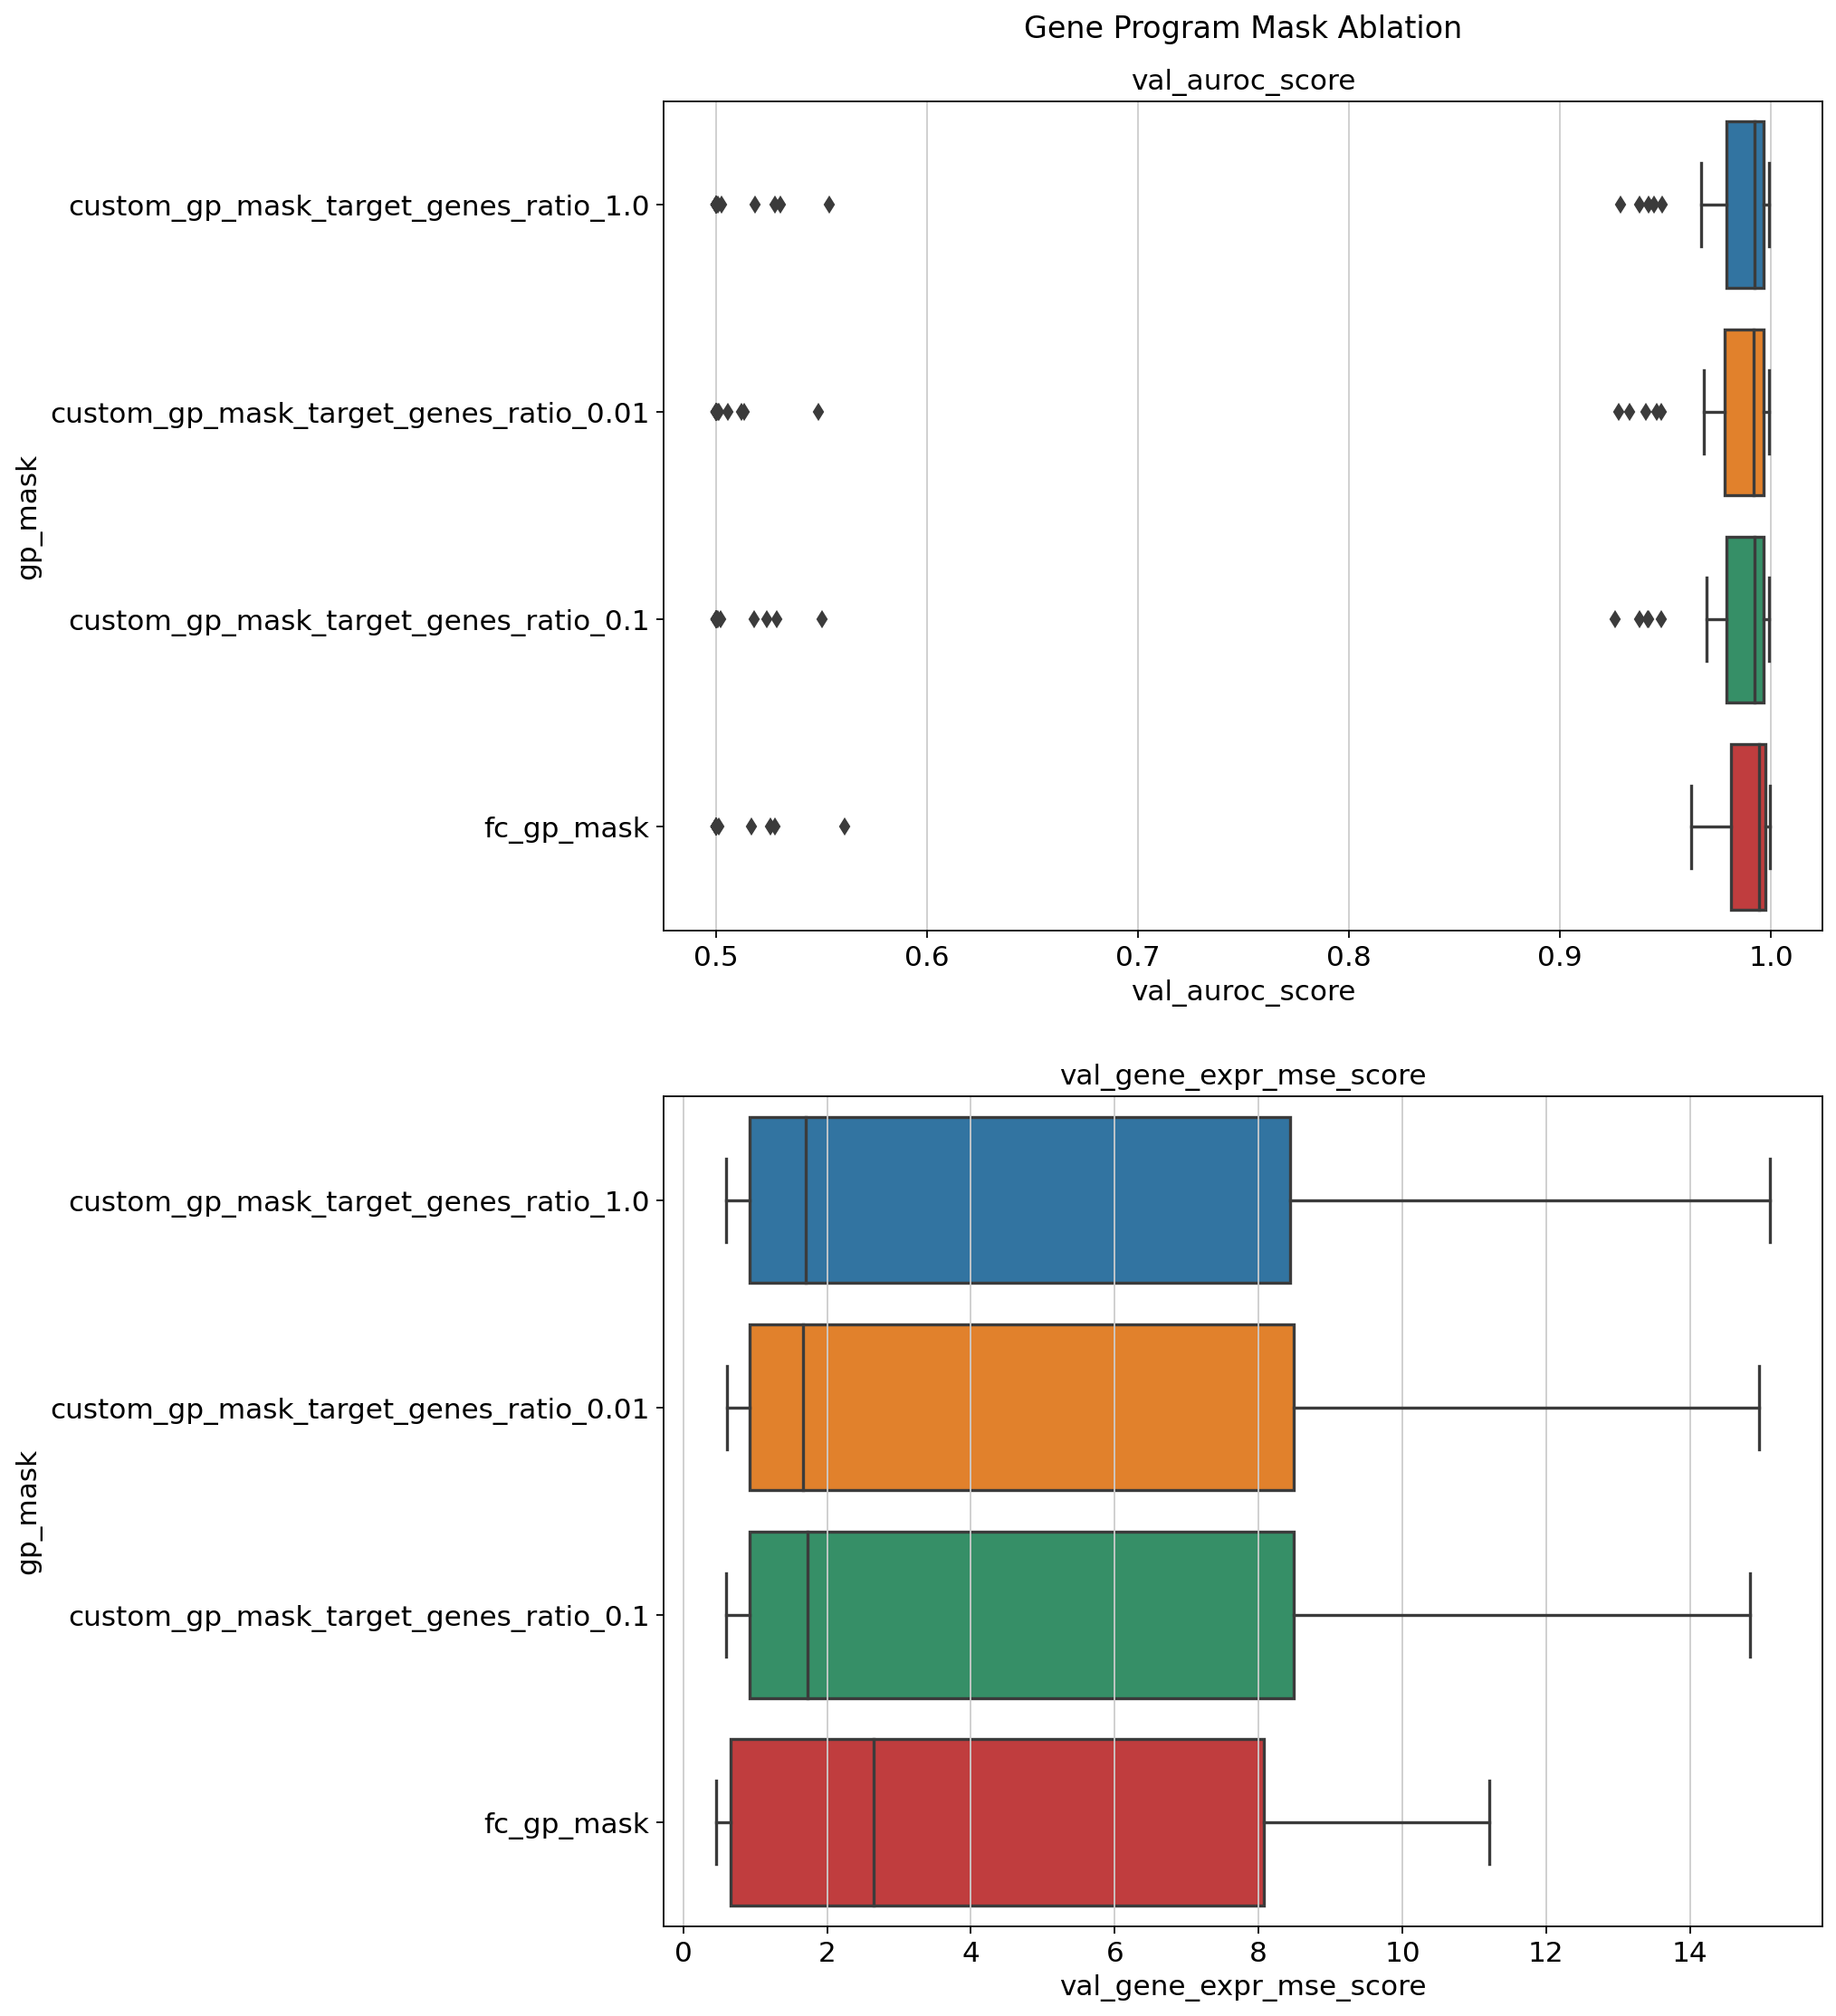

In [47]:
# GP mask plot
plot_metrics(fig_title="Gene Program Mask Ablation",
             df=summary_df,
             group_col="gp_mask",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="gp_mask_ablation_metrics.png")

In [59]:
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

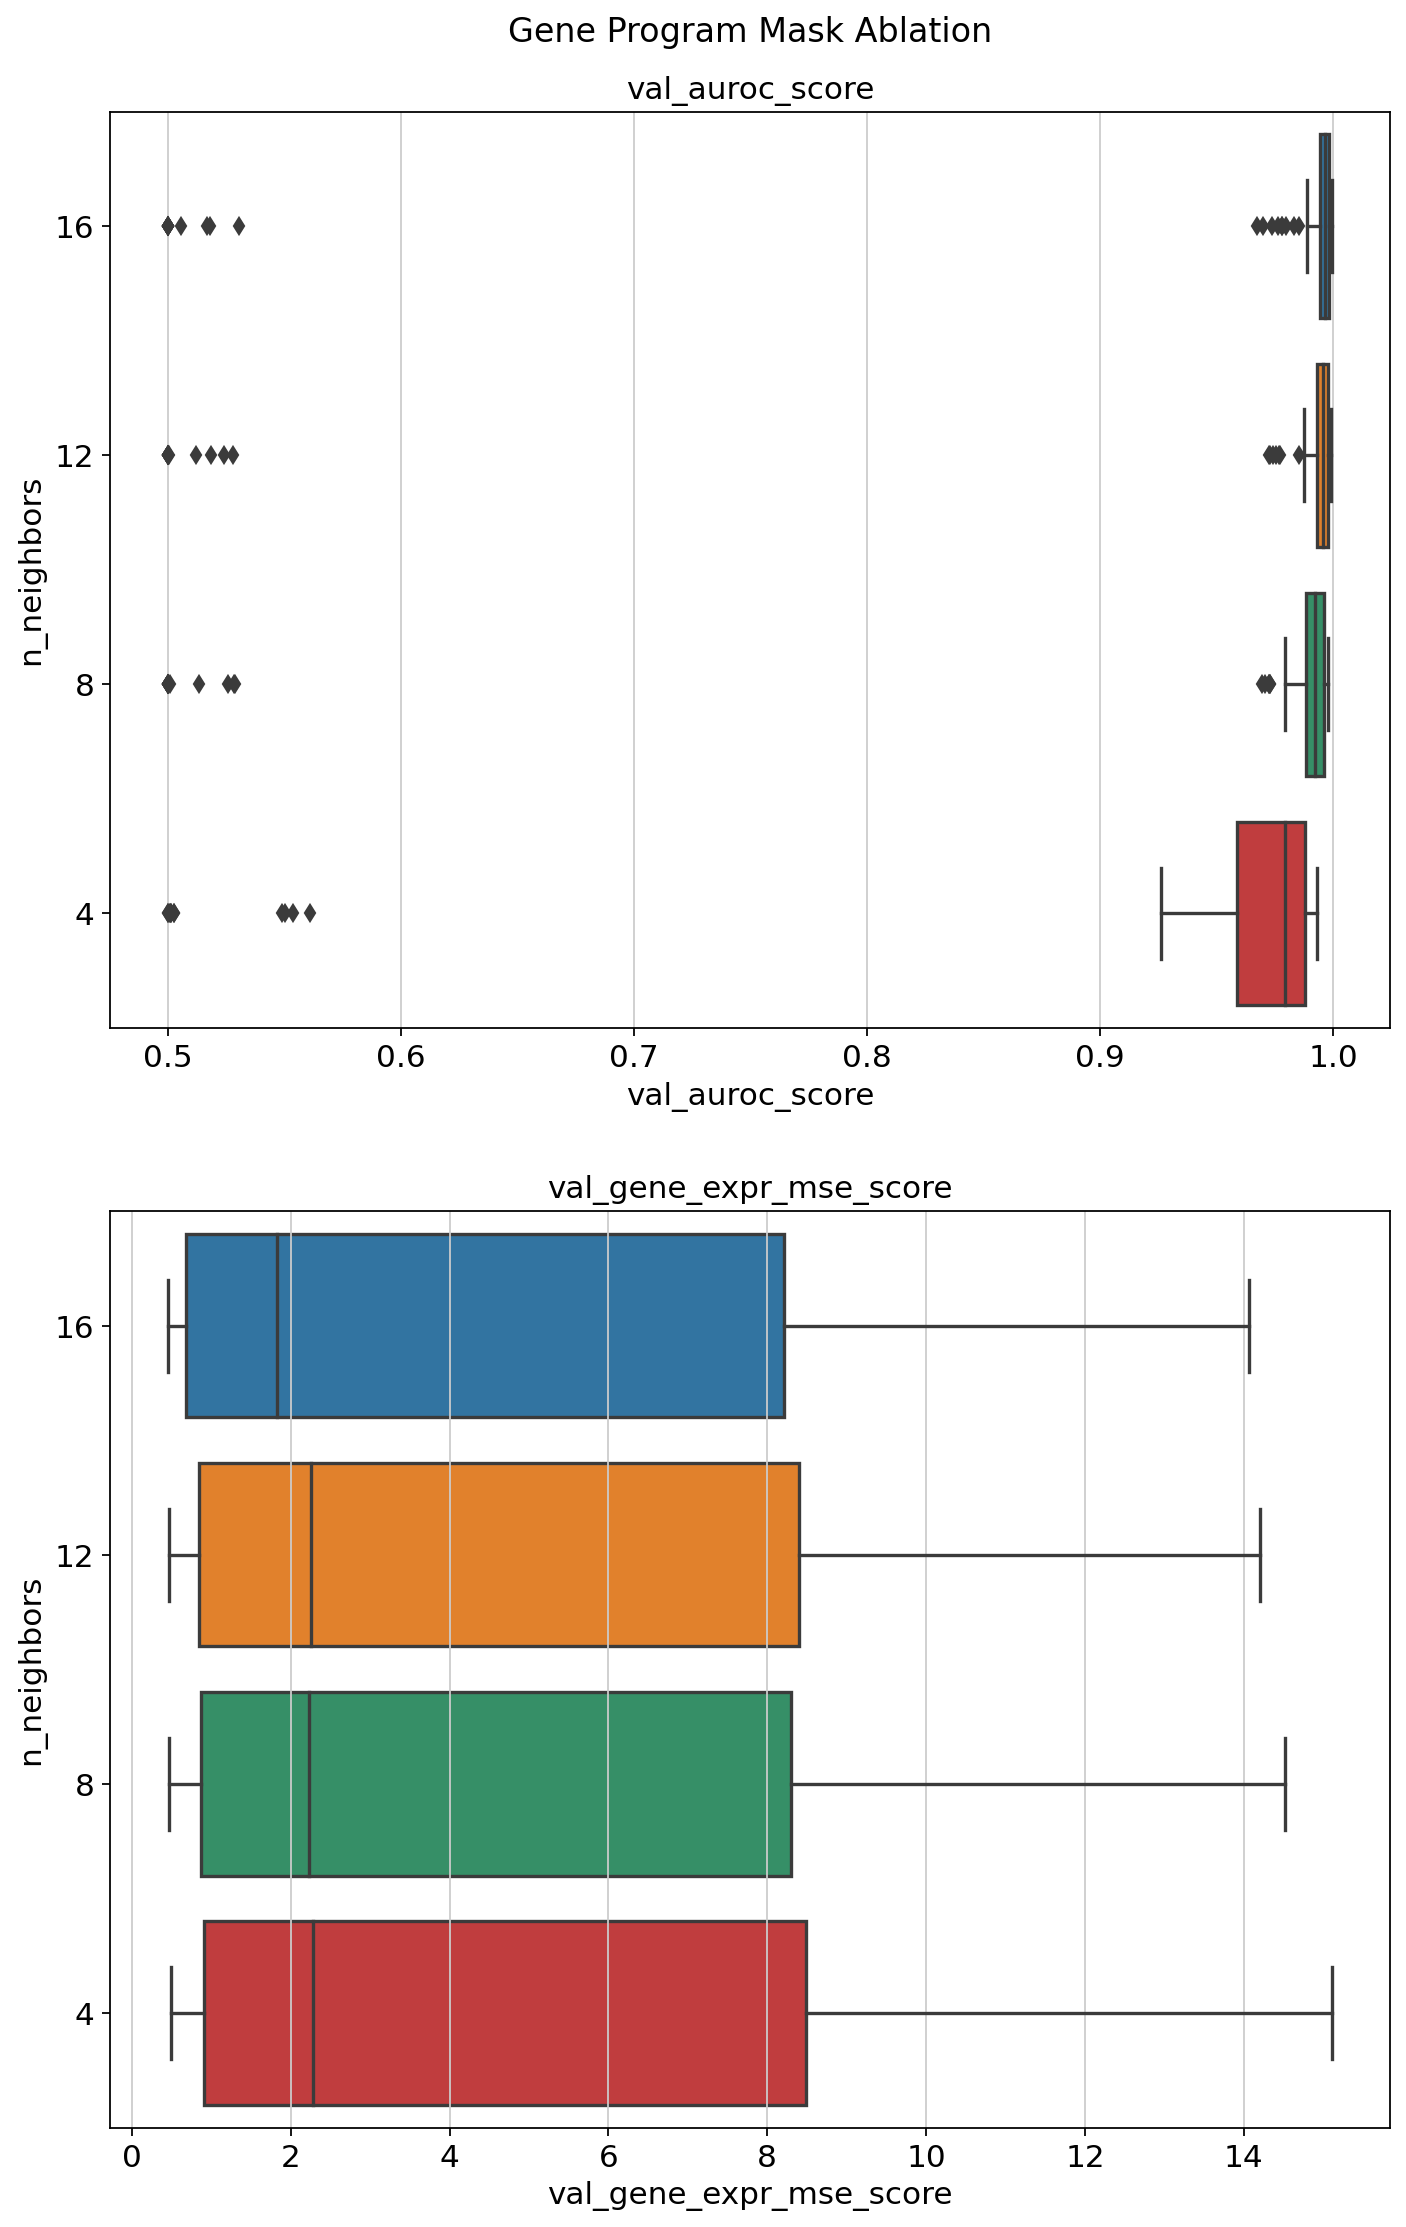

In [60]:
# GP mask plot
plot_metrics(fig_title="Gene Program Mask Ablation",
             df=summary_df,
             group_col="n_neighbors",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score"],
             save_fig=False,
             figure_folder_path=figure_folder_path,
             file_name="gp_mask_ablation_metrics.png")

In [ ]:
# Compute metrics and add to summary df
metrics_df = pd.DataFrame()
for i, dataset in enumerate(datasets):
    # Get timestamps of ablation runs for specific dataset
    timestamps = summary_df[(summary_df["dataset"] == dataset) & (summary_df["val_auroc_score"].notnull())]["timestamp"].tolist()
    
    # Compute metrics for ablation runs models
    current_iteration_metrics_df = compute_metrics(
        artifact_folder_path=artifact_folder_path,
        dataset=dataset,
        task=ablation_task + "_ablation",
        timestamps=timestamps,
        cell_type_key=cell_type_keys[i],
        batch_key=batch_keys[i],
        spatial_key=spatial_key,
        latent_key=latent_key)
    metrics_df = pd.concat([metrics_df, current_iteration_metrics_df], axis=0)
summary_df = pd.merge(summary_df, metrics_df, on=["dataset", "timestamp"], how="left")

In [ ]:
test_df = summary_df.dropna()

In [ ]:
test_df

In [ ]:
ablation_col = "loss_weights"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]
metric_cols = ["cas", "mlami", "gcs", "cca"]
metric_cols_weights = [0.6, 0.6, 0.6, 0.4]
metric_score_cols = [metric_col + "_points" for metric_col in metric_cols]

# Compute ablation points
points_df = compute_ablation_points(
    df=test_df,
    group_col=ablation_col,
    metric_cols=metric_cols,
    metric_cols_weights=metric_cols_weights,
    sort_metric_col="total_score")

In [ ]:
# Plot metrics
for dataset in datasets:
    dataset_df = points_df[points_df["dataset"] == dataset]
    plot_metrics(
        fig_title=f"Loss Weights Ablation: {dataset}",
        df=dataset_df,
        group_col="loss_weights",
        metric_cols=metric_cols,
        plot_ratio_active_gps=False,
        save_fig=False,
        file_name="ablation_metrics.png")

In [ ]:
ablation_col = "loss_weights"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]
metric_cols = ["cas", "mlami", "gcs", "cca"]
metric_cols_weights = [0.6, 0.6, 0.6, 0.4]
metric_score_cols = [metric_col + "_points" for metric_col in metric_cols]

In [ ]:
# Unroll points df and compute means over group columns and score type
unrolled_points_df = pd.melt(points_df, 
   id_vars=group_cols,
   value_vars=metric_score_cols,
   var_name="score_type", 
   value_name="score")

# Compute metric means over all runs
mean_points_df = unrolled_points_df.groupby(group_cols + ["score_type"]).mean()
mean_points_df.reset_index(inplace=True)

In [ ]:
mean_points_df

In [ ]:
group_cols + ["score_type"]

In [ ]:
group_cols

In [ ]:
mean_points_df

In [ ]:
plot_ablation_points(df=mean_points_df,
                     ablation_col=ablation_col,
                     ablation_col_width=7,
                     group_col=dataset_col,
                     metric_cols=metric_score_cols,
                     show=True,
                     save_dir=None,
                     save_name="ablation_results.svg")

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            task=ablation_task + "_ablation",
                            timestamps=timestamps,
                            dataset="xenium_human_breast_cancer",
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=30.,
                            save_fig=False)

### 2.2 Encoder Architecture (GCN vs GATv2)

#### 2.1.2 Categorical Covariates Contrastive Loss

### 2.5 Spatial Neighborhood Graph

In [ ]:
visualize_niches(artifact_folder_path=artifact_folder_path,
                 dataset=dataset,
                 task=ablation_task + "_ablation",
                 timestamps=timestamps,
                 sample_key="batch",
                 latent_key=latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30.)

### 2.5 Gene Program Mask

In [ ]:
"""
# Log additional mlflow param
run_ids = []
runs_info = mlflow.list_run_infos(3)
for run_info in runs_info:
    run = mlflow.get_run(run_info.run_uuid)
    if "add_fc_gps_instead_of_gp_dict_gps" not in run.data.params:
        run_ids.append(run_info.run_uuid)
        
for run_id in run_ids:
    with mlflow.start_run(run_id=run_id) as run:
        mlflow.log_param("add_fc_gps_instead_of_gp_dict_gps", True)
"""